# Final
## Steve Cheney
### RBIF110



In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, squareform
from collections import Counter
import pubchempy as pcp


from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, AllChem, Descriptors, rdMolDescriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import SaltRemover, PandasTools
from rdkit.DataStructs import FingerprintSimilarity
from rdkit import RDLogger

# Suppress RDKit warnings and informational messages
RDLogger.DisableLog('rdApp.*')  # Disables all RDKit logging messages

In [24]:
alz_library_file = "Drugs.csv"
try:
    alz_lib = pd.read_csv(alz_library_file, sep=",", encoding="utf-8")
except UnicodeDecodeError:
    alz_lib = pd.read_csv(alz_library_file, sep=",", encoding="latin-1")

alz_lib = alz_lib.drop(columns=['Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14']).rename(columns={"Canonical SMILES": "SMILES"})
alz_lib.head()

,IPAD_DB_ID,Name,Targeting-protein,Research models,Ref. Link,Molecular Formula,Molecular Weight,IUPAC Name,InChI,InChI Key,SMILES
0,D00001,Donepezil,5-HT6 receptor,In silico and in vitro,https://doi.org/10.1021/acschemneuro.8b00024,C24H29NO3,379.5 g/mol,"2-[(1-benzylpiperidin-4-yl)methyl]-5,6-dimetho...",InChI=1S/C24H29NO3/c1-27-22-14-19-13-20(24(26)...,ADEBPBSSDYVVLD-UHFFFAOYSA-N,COC1=C(C=C2C(=C1)CC(C2=O)CC3CCN(CC3)CC4=CC=CC=...
1,D00002,Donepezil,Acetylcholinesterase (AChE),In silico and in vitro,https://doi.org/10.1021/acschemneuro.8b00024,C24H29NO3,379.5 g/mol,"2-[(1-benzylpiperidin-4-yl)methyl]-5,6-dimetho...",InChI=1S/C24H29NO3/c1-27-22-14-19-13-20(24(26)...,ADEBPBSSDYVVLD-UHFFFAOYSA-N,COC1=C(C=C2C(=C1)CC(C2=O)CC3CCN(CC3)CC4=CC=CC=...
2,D00003,Rolitetracycline,Aβ42 oligomers and fibrils,In vitro,https://doi.org/10.1074/jbc.M608207200,C27H33N3O8,527.6 g/mol,"(4S,4aS,5aS,6S,12aR)-4-(dimethylamino)-1,6,10,...",InChI=1S/C27H33N3O8/c1-26(37)13-7-6-8-16(31)17...,IKQRPFTXKQQLJF-IAHYZSEUSA-N,CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...
3,D00004,Daunomycinol,Aβ1-40,"IMR32 human neuroblastoma cells,",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,C27H31NO10,529.5 g/mol,"(7S,9S)-7-[(2R,4S,5S,6S)-4-amino-5-hydroxy-6-m...",InChI=1S/C27H31NO10/c1-10-22(30)14(28)7-17(37-...,HJEZFVLKJYFNQW-PRFXOSGESA-N,CC1C(C(CC(O1)OC2CC(CC3=C2C(=C4C(=C3O)C(=O)C5=C...
4,D00005,Donepezil,Aβ1-42,In silico and in vitro,https://doi.org/10.1021/acschemneuro.8b00024,C24H29NO3,379.5 g/mol,"2-[(1-benzylpiperidin-4-yl)methyl]-5,6-dimetho...",InChI=1S/C24H29NO3/c1-27-22-14-19-13-20(24(26)...,ADEBPBSSDYVVLD-UHFFFAOYSA-N,COC1=C(C=C2C(=C1)CC(C2=O)CC3CCN(CC3)CC4=CC=CC=...


In [25]:
def get_smiles(pubchem_cid):
    try:
        compound = pcp.Compound.from_cid(pubchem_cid)  # Fetch compound from CID
        return compound.isomeric_smiles  # Extract SMILES string
    except:
        return None  # Return None if CID is invalid or not found

cnss_library_file = "cns_simulants.csv"
try:
    cnss_lib = pd.read_csv(cnss_library_file, sep=",", encoding="utf-8")
except UnicodeDecodeError:
    cnss_lib = pd.read_csv(cnss_library_file, sep=",", encoding="latin-1")

cnss_lib["SMILES"] = cnss_lib["PubChem CID"].apply(get_smiles)

cnss_lib = cnss_lib.drop_duplicates(subset=["PubChem CID"])
cnss_lib = cnss_lib.reset_index(drop=True)

cnss_lib.head()

,Drug Name,Generic Name,PubChem CID,SMILES
0,Vyvanse,lisdexamfetamine,11597698,C[C@@H](CC1=CC=CC=C1)NC(=O)[C@H](CCCCN)N
1,Adipex-P,phentermine,4771,CC(C)(CC1=CC=CC=C1)N
2,Adderall,amphetamine,3007,CC(CC1=CC=CC=C1)N
3,Adderall,dextroamphetamine,5826,C[C@@H](CC1=CC=CC=C1)N
4,Concerta,methylphenidate,4158,COC(=O)C(C1CCCCN1)C2=CC=CC=C2


In [26]:
def standardize_smiles(smiles):
    '''This function takes a non-canonical SMILES and
    returns the canonical version

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - canonical_smiles: str, canonical SMILES of the molecule
    '''

    # Handle any issues with missing values
    if not isinstance(smiles, str) or smiles.strip() == "" or pd.isna(smiles):
        return None
    
    mol = Chem.MolFromSmiles(smiles) #create a mol object from input smiles


    largest_Fragment = rdMolStandardize.LargestFragmentChooser()    
    standardized_smiles = largest_Fragment.choose(mol) #standardize the input string by taking the largest fragment

    canonical_smiles = Chem.MolToSmiles(standardized_smiles) #convert the previous mol object to SMILES using Chem.MolToSmiles()

    ####END
    return canonical_smiles

def get_standard_mol(smiles):
    '''This function takes a non-canonical SMILES converts to the canonical version, then returns the mol object

    Args:
        -smiles: str, non-canonical SMILES of a molecule

    Out:
        - obj: mol object of the converted canonical molecule
    '''
    
    if smiles is None:
        return None

    try:
        mol_obj = Chem.MolFromSmiles(standardize_smiles(smiles))
        return mol_obj if mol_obj else None
    except:
        return None

def get_fingerprint(mol, radius=2, bits=1024):
    if mol is None:
        return None  # Prevents passing None to the RDKit function
    
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=bits)

def clean_df_and_create_mol_col(df, smilesCol, molCol, subset_len=-1, remove_na=True):

    if subset_len == -1:
        data_subset = df.copy()
    else:
        data_subset = df.iloc[:subset_len].copy()

    # Clean data
    data_subset = data_subset[data_subset[smilesCol].notna()]  # Remove NaN values
    data_subset[smilesCol] = data_subset[smilesCol].astype(str)  # Ensure all values are strings

    PandasTools.AddMoleculeColumnToFrame(data_subset, smilesCol=smilesCol, molCol=molCol)

    return data_subset
    
def smiles_to_sdf(dataframe, smiles_col, output_sdf):
    # Create a Pybel molecule object for each SMILES
    molecules = []
    for idx, row in dataframe.iterrows():
        smiles = row[smiles_col]
        mol = pb.readstring("smi", smiles)  # Read the SMILES string
        mol.title = row["name"]  # Set molecule name

        # Add custom properties (e.g., p_np) to the molecule
        if "p_np" in row:
            mol.data["p_np"] = row["p_np"]  # Add the p_np property

        molecules.append(mol)
    
    # Write to an SDF file
    with pb.Outputfile("sdf", output_sdf, overwrite=True) as sdf_file:
        for mol in molecules:
            sdf_file.write(mol)

def extract_properties_from_sdf(sdf_file):
    supplier = Chem.SDMolSupplier(sdf_file)
    data = []
    for mol in supplier:
        if mol is not None:  # Ensure valid molecule
            props = {
                "name": mol.GetProp("_Name"),
                "p_np": mol.GetProp("p_np") if mol.HasProp("p_np") else None,
                "Molecular_Weight": Descriptors.MolWt(mol),
                "LogP": Descriptors.MolLogP(mol),
                "H_Bond_Donors": Descriptors.NumHDonors(mol),
                "H_Bond_Acceptors": Descriptors.NumHAcceptors(mol),
                "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
                "TPSA": Descriptors.TPSA(mol),
            }
            data.append(props)
    return pd.DataFrame(data)

def calculate_similarity(df, query_smiles):
    """
    Calculate Tanimoto similarity between a query SMILES and a dataframe of molecules

    Args:
        - df: pd.Dataframe, DataFrame containing a 'SMILES' column
        - query_smiles: str, Query molecule in SMILES format

    Returns:
        pd.DataFrame
    """

    df_copy = df.copy()

    # Convert query SMILES to RDKit Mol object
    query_mol = Chem.MolFromSmiles(query_smiles)
    if query_mol is None:
        raise ValueError("Invalid SMILES string provided for query.")

    # Generate fingerprint for query molecule
    query_fp = AllChem.GetMorganFingerprintAsBitVect(query_mol, 2, nBits=1024)

    # Compute similarity scores
    similarity_scores = [
        (DataStructs.TanimotoSimilarity(query_fp, AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
         if mol is not None else None)
        for mol in df_copy['standardized_mol']
    ]

    # Add similarity scores to dataframe
    df_copy['similarity'] = similarity_scores
    df_sorted = df_copy.sort_values(by='similarity', ascending=False).reset_index(drop=True)

    return df_sorted

def calculate_descriptors(mol):
    if mol:
        return {
            "Molecular_Weight": Descriptors.MolWt(mol),
            "Rotatable_Bonds": Descriptors.NumRotatableBonds(mol),
            "Aromatic_Bonds": rdMolDescriptors.CalcNumAromaticRings(mol),
            "ClogP": Descriptors.MolLogP(mol),
            "TPSA": Descriptors.TPSA(mol),
        }
    else:
        return None

In [ ]:
# Clean the data to ignore any NaN smiles values and subset data if needed
alz_lib = clean_df_and_create_mol_col(alz_lib, 'SMILES', 'mol')
alz_lib['standardized_mol'] = alz_lib['SMILES'].apply(get_standard_mol)
alz_lib['fingerprint'] = alz_lib['standardized_mol'].apply(get_fingerprint)

descriptor_data = alz_lib["standardized_mol"].apply(calculate_descriptors)

filtered_data = [d for d in descriptor_data if d is not None]
descriptor_df = pd.DataFrame(filtered_data)
alz_lib = pd.concat([alz_lib, descriptor_df], axis=1)
print(alz_lib.shape)
alz_lib = alz_lib.dropna()  # Drops all rows with NaN values in any column
print(alz_lib.shape)
alz_lib.head()


In [ ]:
# Clean the data to ignore any NaN smiles values and subset data if needed
cnss_lib = clean_df_and_create_mol_col(cnss_lib, 'SMILES', 'mol')
cnss_lib['standardized_mol'] = cnss_lib['SMILES'].apply(get_standard_mol)
cnss_lib['fingerprint'] = cnss_lib['standardized_mol'].apply(get_fingerprint)

descriptor_data = cnss_lib["standardized_mol"].apply(calculate_descriptors)

filtered_data = [d for d in descriptor_data if d is not None]
descriptor_df = pd.DataFrame(filtered_data)
cnss_lib = pd.concat([cnss_lib, descriptor_df], axis=1)
print(cnss_lib.shape)
cnss_lib = cnss_lib.dropna()  # Drops all rows with NaN values in any column
print(cnss_lib.shape)
cnss_lib.head()

(27, 12)
(27, 12)


,Drug Name,Generic Name,PubChem CID,SMILES,mol,standardized_mol,fingerprint,Molecular_Weight,Rotatable_Bonds,Aromatic_Bonds,ClogP,TPSA
0,Vyvanse,lisdexamfetamine,11597698,C[C@@H](CC1=CC=CC=C1)NC(=O)[C@H](CCCCN)N,<rdkit.Chem.rdchem.Mol object at 0x7f9d378b3ed0>,<rdkit.Chem.rdchem.Mol object at 0x7f9d2010fe60>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",263.385,8,1,1.1901,81.14
1,Adipex-P,phentermine,4771,CC(C)(CC1=CC=CC=C1)N,<rdkit.Chem.rdchem.Mol object at 0x7f9d378b3d10>,<rdkit.Chem.rdchem.Mol object at 0x7f9d2010fdf0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",149.237,2,1,1.9664,26.02
2,Adderall,amphetamine,3007,CC(CC1=CC=CC=C1)N,<rdkit.Chem.rdchem.Mol object at 0x7f9d378b3ca0>,<rdkit.Chem.rdchem.Mol object at 0x7f9d2010fd80>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",135.210,2,1,1.5763,26.02
3,Adderall,dextroamphetamine,5826,C[C@@H](CC1=CC=CC=C1)N,<rdkit.Chem.rdchem.Mol object at 0x7f9d378d9d90>,<rdkit.Chem.rdchem.Mol object at 0x7f9d2010fd10>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",135.210,2,1,1.5763,26.02
4,Concerta,methylphenidate,4158,COC(=O)C(C1CCCCN1)C2=CC=CC=C2,<rdkit.Chem.rdchem.Mol object at 0x7f9d3787a180>,<rdkit.Chem.rdchem.Mol object at 0x7f9d2010fca0>,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",233.311,3,1,2.0853,38.33


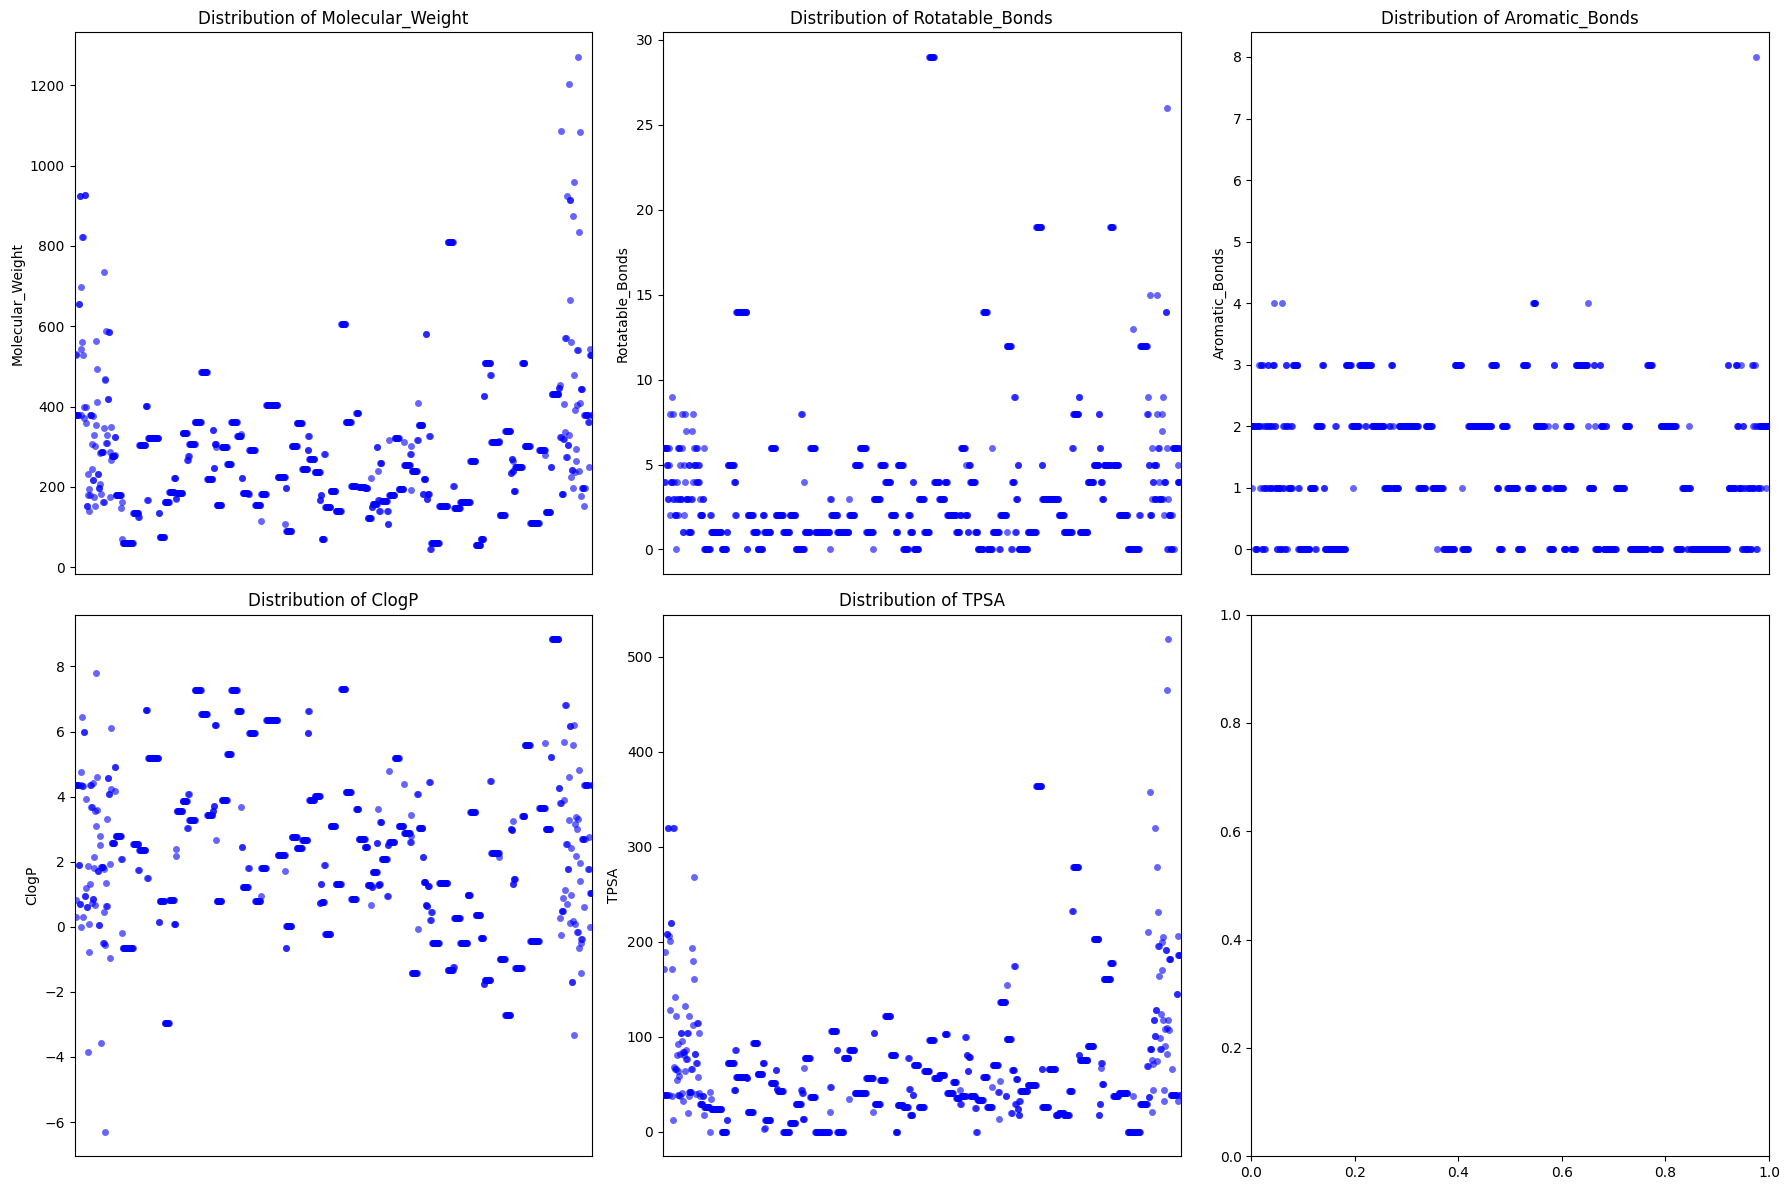

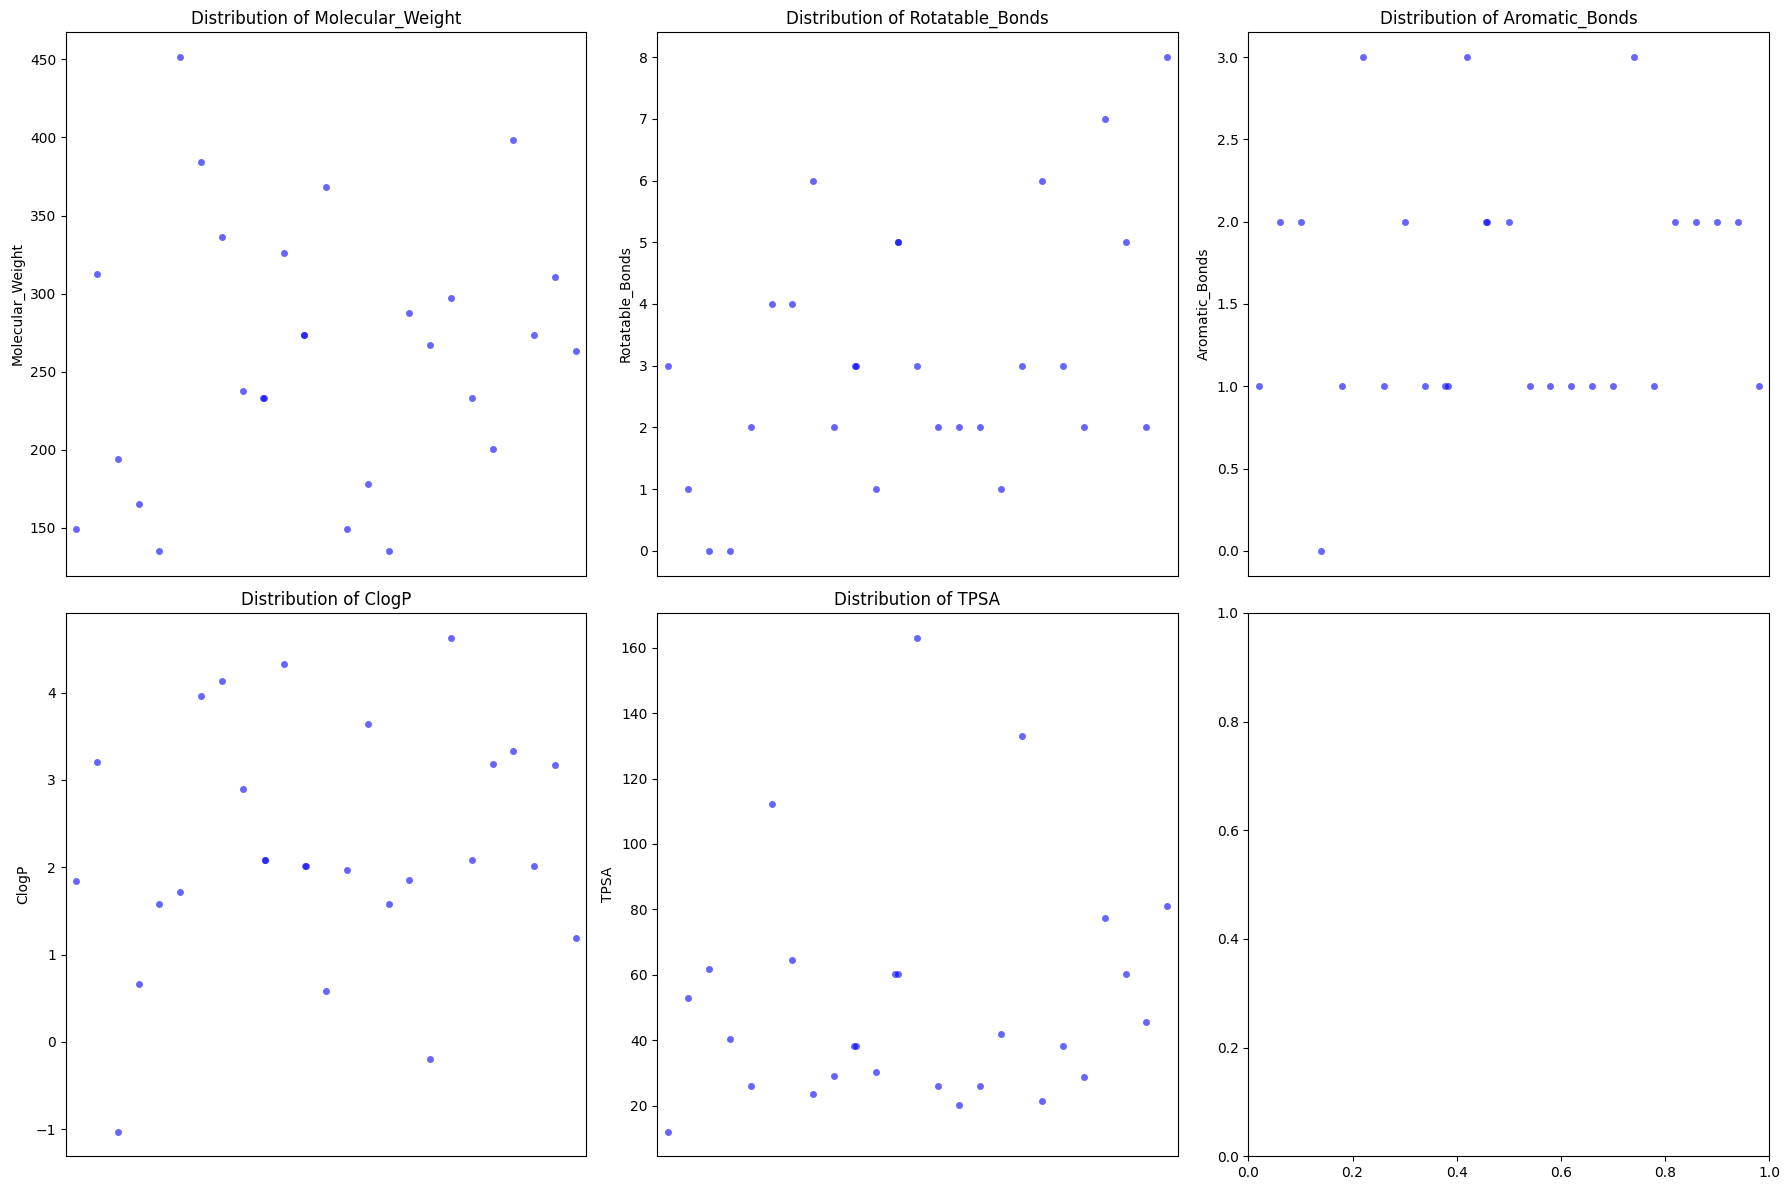

In [ ]:
def plot_property_distributions(df,id):
    """
    Generate jitter plots for the distribution of selected molecular properties
    """
    properties = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]

    # Create subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, prop in enumerate(properties):
        sns.stripplot(x=id, y=prop, data=df, jitter=True, alpha=0.6, color="blue", ax=axes[i])        
        axes[i].set_xticks([])  # Remove x-axis labels
        axes[i].set_title(f"Distribution of {prop}")
        axes[i].set_ylabel(prop)
        axes[i].set_xlabel("")

    plt.tight_layout()
    plt.show()

plot_property_distributions(alz_lib, id="IPAD_DB_ID")
plot_property_distributions(cnss_lib, id="PubChem CID")


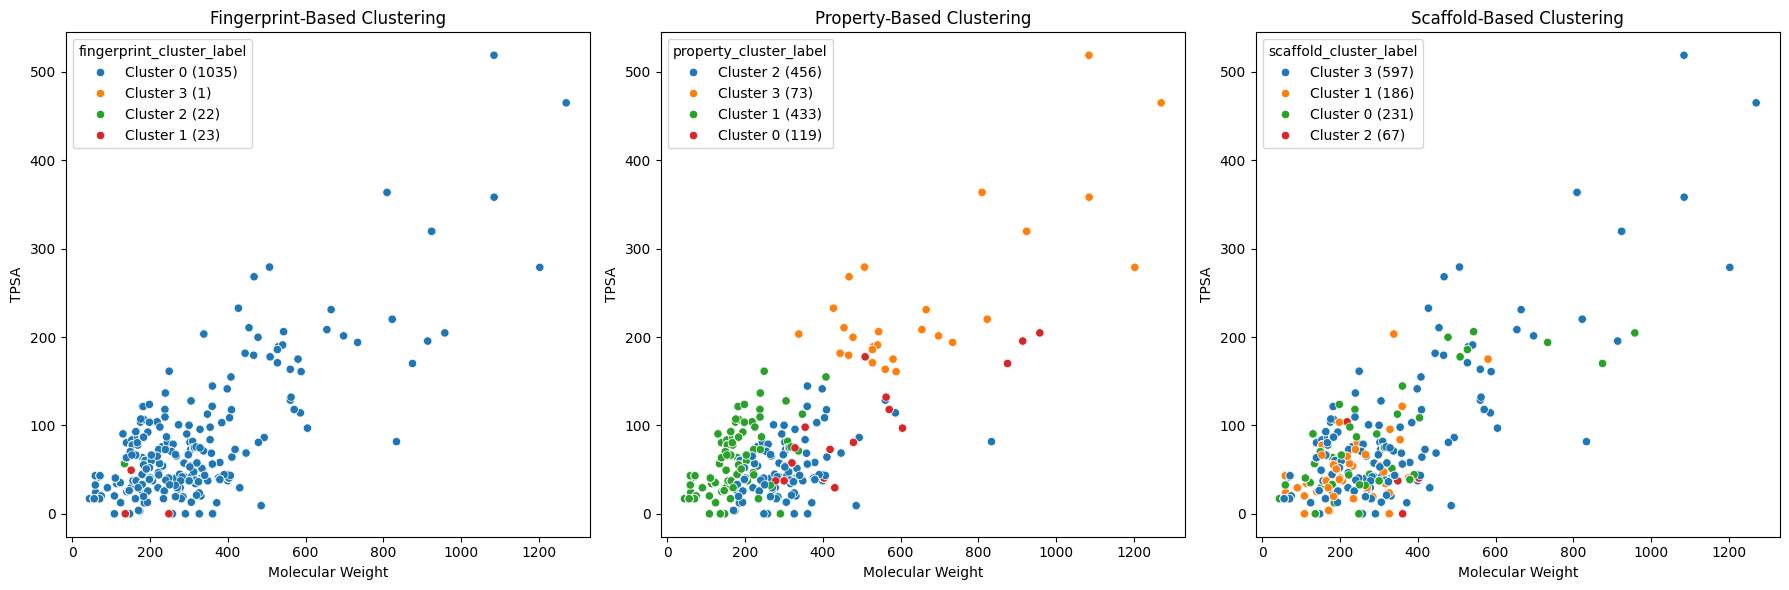

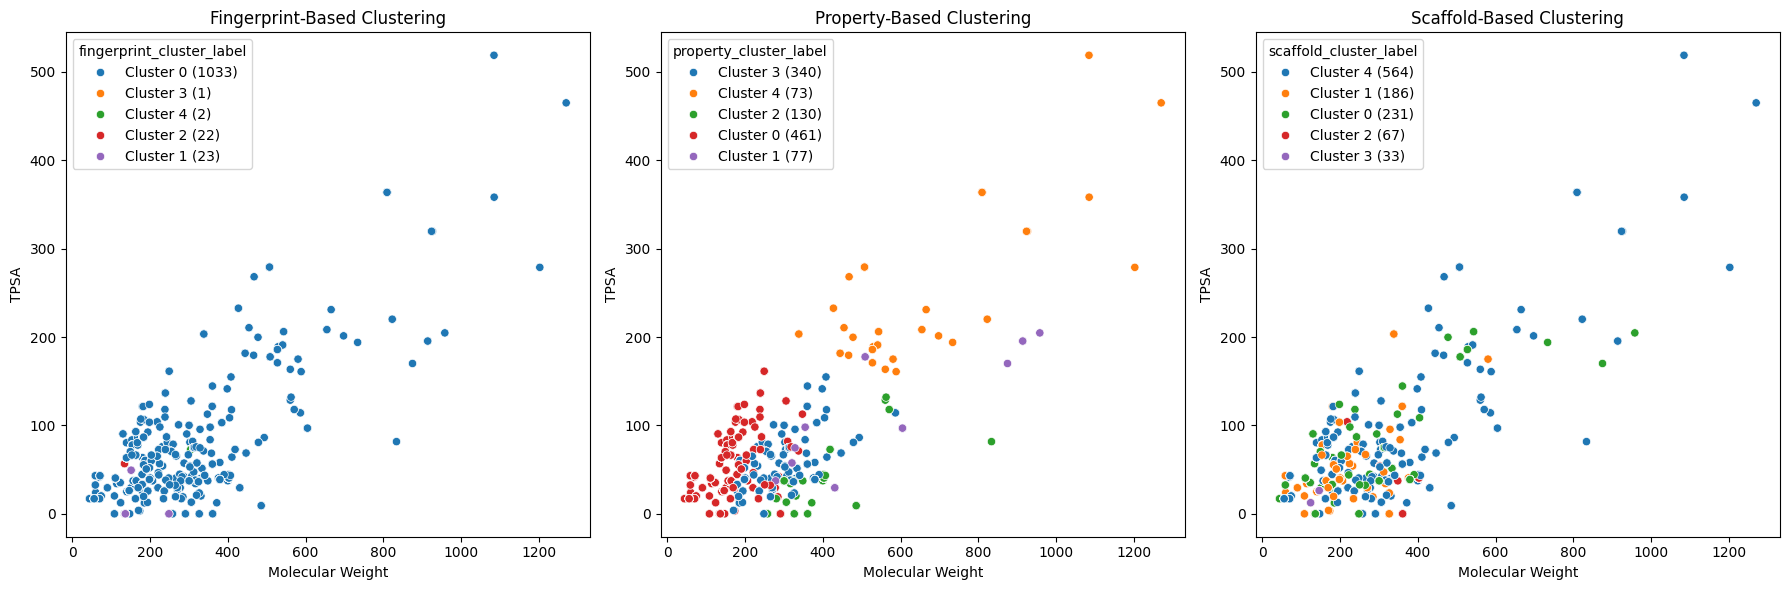

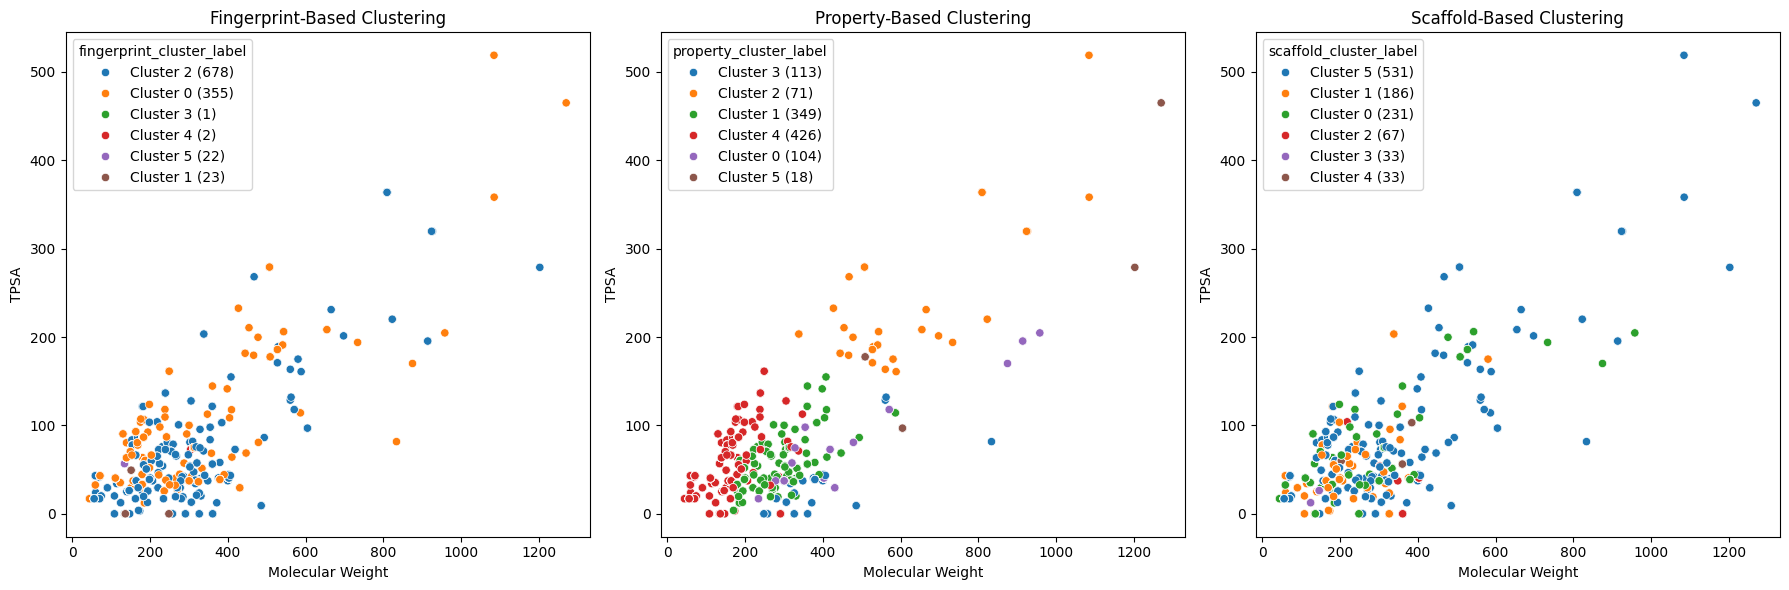

In [ ]:
def cluster_by_fingerprint(df, n_clusters=5):
    """Hierarchical clustering based on Tanimoto similarity."""
    
    # Remove molecules with missing fingerprints
    df = df[df['fingerprint'].notna()].copy()
    fingerprints = df['fingerprint'].tolist()
    num_mols = len(fingerprints)

    if num_mols == 0:
        raise ValueError("No valid fingerprints available for clustering!")

    # Compute Tanimoto similarity matrix
    similarity_matrix = np.zeros((num_mols, num_mols))
    for i in range(num_mols):
        for j in range(i, num_mols):
            if fingerprints[i] is not None and fingerprints[j] is not None:
                sim = Chem.DataStructs.TanimotoSimilarity(fingerprints[i], fingerprints[j])
            else:
                sim = 0  # Default similarity for None cases
            similarity_matrix[i, j] = sim
            similarity_matrix[j, i] = sim

    distance_matrix = 1 - similarity_matrix  # Convert similarity to distance

    # Use metric instead of affinity
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='average')
    df['fingerprint_cluster'] = clustering.fit_predict(distance_matrix)
    return df


def cluster_by_properties(df, n_clusters=5):
    """K-means clustering on normalized molecular properties."""
    properties = ["Molecular_Weight", "Rotatable_Bonds", "Aromatic_Bonds", "ClogP", "TPSA"]
    scaler = MinMaxScaler()
    normalized_props = scaler.fit_transform(df[properties])
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['property_cluster'] = kmeans.fit_predict(normalized_props)
    return df

def get_murcko_scaffold(mol):
    """Extract Murcko scaffold."""
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol) if mol else None

def cluster_by_scaffold(df, n_scaff=4):
    """Clusters molecules by Murcko scaffold, grouping common scaffolds separately."""
    df['scaffold'] = df['standardized_mol'].apply(get_murcko_scaffold)
    scaffold_counts = Counter(df['scaffold'].dropna())
    top_scaffolds = [scaffold for scaffold, count in scaffold_counts.most_common(n_scaff)]  # Top n scaffolds

    def assign_scaffold_cluster(scaffold):
        return top_scaffolds.index(scaffold) if scaffold in top_scaffolds else len(top_scaffolds)  # Assign 'other'

    df['scaffold_cluster'] = df['scaffold'].apply(assign_scaffold_cluster)
    return df

def main_clustering_pipeline(df, n_clust=5):
    """Runs all clustering methods, computes similarity scores, and visualizes results."""
    df = cluster_by_fingerprint(df, n_clust)
    df = cluster_by_properties(df, n_clust)
    df = cluster_by_scaffold(df, n_clust-1)

    # Plot clustering results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    cluster_types = ['fingerprint_cluster', 'property_cluster', 'scaffold_cluster']
    titles = ["Fingerprint-Based Clustering", "Property-Based Clustering", "Scaffold-Based Clustering"]

    for i, cluster_col in enumerate(cluster_types):
        # Count occurrences of each cluster
        cluster_counts = df[cluster_col].value_counts().to_dict()
        # Rename clusters
        df[f"{cluster_col}_label"] = df[cluster_col].apply(
            lambda x: f"Cluster {x} ({cluster_counts[x]})"
        )

        # Plot with updated labels
        sns.scatterplot(
            x=df['Molecular_Weight'], 
            y=df['TPSA'], 
            hue=df[f"{cluster_col}_label"], 
            palette="tab10", 
            ax=axes[i]
        )

        axes[i].set_title(titles[i])
        axes[i].set_xlabel("Molecular Weight")
        axes[i].set_ylabel("TPSA")

    plt.tight_layout()
    plt.show()
    
    return df

clustered_df_4 = main_clustering_pipeline(alz_lib, n_clust=4)
clustered_df_5 = main_clustering_pipeline(alz_lib, n_clust=5)
clustered_df_6 = main_clustering_pipeline(alz_lib, n_clust=6)


In [ ]:
clustered_df_5.head()

,IPAD_DB_ID,Name,Targeting-protein,Research models,Ref. Link,Molecular Formula,Molecular Weight,IUPAC Name,InChI,InChI Key,...,Aromatic_Bonds,ClogP,TPSA,fingerprint_cluster,property_cluster,scaffold,scaffold_cluster,fingerprint_cluster_label,property_cluster_label,scaffold_cluster_label
0,D00001,Donepezil,5-HT6 receptor,In silico and in vitro,https://doi.org/10.1021/acschemneuro.8b00024,C24H29NO3,379.5 g/mol,"2-[(1-benzylpiperidin-4-yl)methyl]-5,6-dimetho...",InChI=1S/C24H29NO3/c1-27-22-14-19-13-20(24(26)...,ADEBPBSSDYVVLD-UHFFFAOYSA-N,...,2.0,4.3611,38.77,0,3,O=C1c2ccccc2CC1CC1CCN(Cc2ccccc2)CC1,4,Cluster 0 (1033),Cluster 3 (340),Cluster 4 (564)
1,D00002,Donepezil,Acetylcholinesterase (AChE),In silico and in vitro,https://doi.org/10.1021/acschemneuro.8b00024,C24H29NO3,379.5 g/mol,"2-[(1-benzylpiperidin-4-yl)methyl]-5,6-dimetho...",InChI=1S/C24H29NO3/c1-27-22-14-19-13-20(24(26)...,ADEBPBSSDYVVLD-UHFFFAOYSA-N,...,2.0,4.3611,38.77,0,3,O=C1c2ccccc2CC1CC1CCN(Cc2ccccc2)CC1,4,Cluster 0 (1033),Cluster 3 (340),Cluster 4 (564)
2,D00003,Rolitetracycline,Aβ42 oligomers and fibrils,In vitro,https://doi.org/10.1074/jbc.M608207200,C27H33N3O8,527.6 g/mol,"(4S,4aS,5aS,6S,12aR)-4-(dimethylamino)-1,6,10,...",InChI=1S/C27H33N3O8/c1-26(37)13-7-6-8-16(31)17...,IKQRPFTXKQQLJF-IAHYZSEUSA-N,...,1.0,0.3132,170.87,0,4,O=C1CC2CC3Cc4ccccc4C=C3C(=O)C2C=C1C(=O)NCN1CCCC1,4,Cluster 0 (1033),Cluster 4 (73),Cluster 4 (564)
3,D00004,Daunomycinol,Aβ1-40,"IMR32 human neuroblastoma cells,",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...,C27H31NO10,529.5 g/mol,"(7S,9S)-7-[(2R,4S,5S,6S)-4-amino-5-hydroxy-6-m...",InChI=1S/C27H31NO10/c1-10-22(30)14(28)7-17(37-...,HJEZFVLKJYFNQW-PRFXOSGESA-N,...,2.0,0.8207,189.00,0,4,O=C1c2ccccc2C(=O)c2cc3c(cc21)CCCC3OC1CCCCO1,4,Cluster 0 (1033),Cluster 4 (73),Cluster 4 (564)
4,D00005,Donepezil,Aβ1-42,In silico and in vitro,https://doi.org/10.1021/acschemneuro.8b00024,C24H29NO3,379.5 g/mol,"2-[(1-benzylpiperidin-4-yl)methyl]-5,6-dimetho...",InChI=1S/C24H29NO3/c1-27-22-14-19-13-20(24(26)...,ADEBPBSSDYVVLD-UHFFFAOYSA-N,...,2.0,4.3611,38.77,0,3,O=C1c2ccccc2CC1CC1CCN(Cc2ccccc2)CC1,4,Cluster 0 (1033),Cluster 3 (340),Cluster 4 (564)
